# Coverage Growth Rate (Multi Parameter) 


This is the Notebook used to analyze whether parameter control impacts the coverage growth rate.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, g_offset, sigma, sigma_a, sigma_b, sigma_g]


<Figure size 400x300 with 0 Axes>

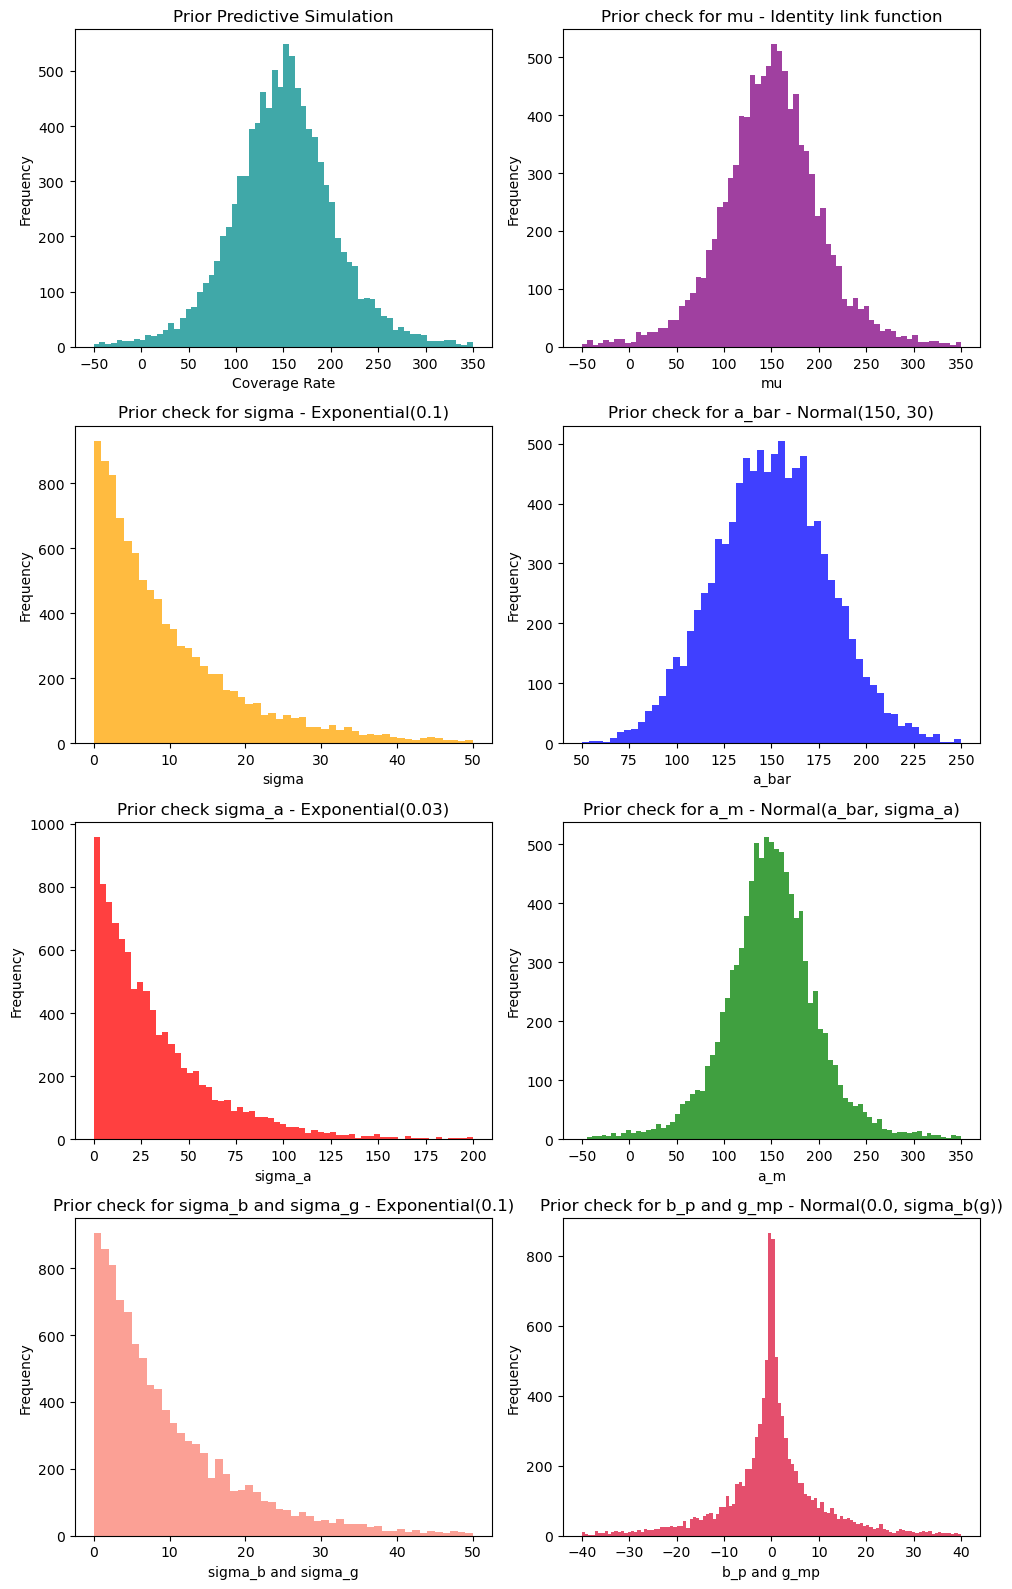

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, s_g, a_bar_mu, a_bar_sigma, e):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Module, Parameter and Interaction effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        sigma_g = pm.Exponential('sigma_g', s_g)
        
        # Modules, Parameters and Interactions effects
        # With non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)

        g_offset = pm.Normal('g_offset', mu=0, sigma=1)
        g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)


        # Link function (identity), same input as output
        pm.Deterministic('mu_before', a_m + b_p + g_mp)
        pm.Deterministic('mu', a_m + b_p + g_mp)
        
        # Likelihood distribution spread
        pm.Exponential('sigma', e)
        
        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_sigma = idata.prior['sigma'].values.flatten()

    # Use mu and sigma priors as parameters for a Normal distribution to sample observations
    simulated_observations = np.random.normal(loc=prior_mu, scale=prior_sigma)
    
    # Plot histogram of observations 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Prior Predictive Simulation', 'Coverage Rate',
                                     'darkcyan', bin_range=(-50,350))


    # Plot priors for the different parameters
    plots = [
        observation_plot,
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior check for mu - Identity link function', 'mu', 'purple', bin_range=(-50, 350)),
        HistogramPlot(idata.prior['sigma'].values.flatten(), 'Prior check for sigma - Exponential(0.1)', 'sigma', 'orange', bin_range=(0,50)),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior check for a_bar - Normal(150, 30)', 'a_bar', 'blue', bin_range=(50,250)),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior check sigma_a - Exponential(0.03)', 'sigma_a', 'red', bin_range=(0,200)),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior check for a_m - Normal(a_bar, sigma_a)', 'a_m', 'green', bin_range=(-50, 350)),
        HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior check for sigma_b and sigma_g - Exponential(0.1)', 'sigma_b and sigma_g', 'salmon', bin_range=(0,50)),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior check for b_p and g_mp - Normal(0.0, sigma_b(g))', 'b_p and g_mp', 'crimson', bin_range=(-40, 40)),

    ]

    plot_histograms(plots, 4, 2, figsize=(10,16), save_img=True, prefix_name="coverage_rate_single", output_folder="prior_checks/coverage_rate_single")

perform_prior_check(0.03, 0.1, 0.1, 150 , 30, 0.1)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=0.05, min=0, max=1, step=0.001, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Sigma_beta (sigma_b):')
#s_g = FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Sigma_gamma (sigma_g):')
#a_bar_mu = FloatSlider(value=150, min=0, max=300, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=30, min=0, max=300, step=0.1, description='alpha bar sigma (a_bar_sigma):')
#exp_value = FloatSlider(value=0.1, min=0, max=2, step=0.05, description='exponential value (exp_value):')

#interact(perform_prior_check, s_a=s_a, s_b=s_b, s_g=s_g, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma,e=exp_value)

# Model specification

### Data Preperation

In [1]:
import pandas as pd
import numpy as np
from utils.design_matrix_creator import get_design_matricies

# Load the CSV file
data = pd.read_csv("../multi_parameter/combined_data/statistics.csv")

# Select columns for the coverage timeline
coverage_data = data.filter(regex='^CoverageTimeline_T')

# Calculate the integral for each row using the trapezoidal rule
data['IntegralValue'] = coverage_data.apply(lambda row: np.trapz(row, dx=1), axis=1)
            
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'IntegralValue')

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


### Execute the Model

In [ ]:
import pymc as pm
with pm.Model():
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=150, sigma=30)
    
    # Standard deviations for Module, Parameter and Interaction effects
    sigma_a = pm.Exponential('sigma_a', 0.03)
    sigma_b = pm.Exponential('sigma_b', 0.1)
    sigma_g = pm.Exponential('sigma_g', 0.1)
    
    # Non-centered parameterizations for module, parameter and interaction effect.
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=66)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=1584)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct module, parameter and interaction for each run
    identity_a = pm.math.dot(module_matrix, a_m)
    identity_b = pm.math.dot(parameter_matrix, b_p)
    identity_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (identity), same input as output
    mu = pm.Deterministic('mu', identity_a + identity_b + identity_g)
    
    # Normal distribution likelihood with parameter mu and sigma
    sigma = pm.Exponential('sigma', 0.1) # standard deviation
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=observation_matrix['IntegralValue'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4, return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)

### Save the results

In [3]:
import arviz as az

az.to_netcdf(trace, "coverage_rate_model_multi_parameter.nc")

'coverage_rate_single_parameter_2.nc'

# Data analysis

### Generate summary object

In [2]:
import arviz as az
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
import pandas as pd
pd.set_option('display.max_rows', 2000)


trace = az.from_netcdf("../multi_parameter/coverage_rate_model_multi_parameter.nc")
variable_list = ['a_m', 'b_p', 'g_mp', 'a_bar', 'sigma_a', 'sigma_b', 'sigma_g', 'sigma']
transformations = {}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)

### Replace numeric identifiers with descriptive identifiers

In [3]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies
import pandas as pd


_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'Coverage')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean      sd  hdi_5.5%  \
g_mp[return_from_generator x ChromLen|TestDelet...   -1.521   1.472    -3.763   
g_mp[return_from_generator x RandPert|TestInser...   -1.130   1.245    -3.073   
g_mp[return_from_generator x Elite|TestChangeProb]   -1.105   1.240    -3.036   
g_mp[return_from_generator x ChromLen|TourSize]      -0.906   1.129    -2.770   
g_mp[return_from_generator x StatemInsertProb|T...   -0.889   1.136    -2.641   
g_mp[return_from_generator x TestInsertProb|Tou...   -0.858   1.116    -2.608   
g_mp[return_from_generator x Elite|TestDeleteProb]   -0.781   1.098    -2.526   
g_mp[yield_from x TestChangeProb|TestInsertionP...   -0.734   1.055    -2.430   
g_mp[return_from_generator x Crossover|RandPert]     -0.639   1.025    -2.273   
g_mp[return_from_generator x TestInsertProb|Tes...   -0.619   1.008    -2.241   
g_mp[return_from_generator x Elite|TourSize]         -0.603   1.007    -2.246   
g_mp[return_from_generator x ChromLen|Pop]           -0.600   1.011    -2.227   
g_mp[return_from_generator x Pop|TestChangeProb]     -0.566   1.004    -2.200   
g_mp[return_from_generator x RandPert|TestChang...   -0.566   1.010    -2.231   
g_mp[return_from_generator x Pop|TestDeleteProb]     -0.557   1.009    -2.292   
g_mp[yield_from x Elite|TestChangeProb]              -0.546   0.982    -2.045   
g_mp[yield_from x Crossover|RandPert]                -0.524   0.982    -2.117   
g_mp[yield_from x ChromLen|Pop]                      -0.517   0.979    -2.075   
g_mp[return_from_generator x ChangeParamProb|Cr...   -0.513   0.996    -2.199   
g_mp[return_from_generator x TestDeleteProb|Tes...   -0.500   0.977    -2.138   
g_mp[yield_from x Pop|StatemInsertProb]              -0.498   0.990    -2.075   
g_mp[return_from_generator x ChromLen|Crossover]     -0.485   0.974    -2.090   
g_mp[py_base x ChromLen|StatemInsertProb]            -0.482   0.977    -2.028   
g_mp[yield_from x StatemInsertProb|TestDeleteProb]   -0.459   0.968    -2.008   
g_mp[return_from_generator x ChromLen|TestChang...   -0.438   0.964    -2.072   
g_mp[return_from_generator x TestDeleteProb|Tes...   -0.438   0.971    -2.004   
g_mp[py_base x Pop|RandPert]                         -0.432   0.959    -2.003   
g_mp[return_from_generator x ChromLen|StatemIns...   -0.430   0.961    -1.967   
g_mp[py_base x ChromLen|Pop]                         -0.397   0.952    -2.002   
g_mp[return_from_generator x StatemInsertProb|T...   -0.392   0.952    -1.872   
g_mp[positional_validation x Crossover|TourSize]     -0.381   0.948    -1.949   
g_mp[positional_validation x Crossover|StatemIn...   -0.377   0.970    -1.957   
g_mp[positional_validation x StatemInsertProb|T...   -0.377   0.928    -1.893   
g_mp[positional_validation x ChangeParamProb|Ra...   -0.376   0.957    -1.944   
g_mp[positional_validation x Elite|TestInsertProb]   -0.376   0.941    -1.914   
g_mp[positional_validation x TestChangeProb|Tes...   -0.374   0.952    -1.943   
g_mp[positional_validation x ChangeParamProb|Te...   -0.374   0.944    -1.971   
g_mp[positional_validation x Elite|TourSize]         -0.374   0.942    -1.879   
g_mp[positional_validation x Pop|TestInsertProb]     -0.373   0.937    -1.932   
g_mp[positional_validation x TestChangeProb|Tou...   -0.372   0.950    -1.929   
g_mp[yield_from x RandPert|TestDeleteProb]           -0.371   0.953    -1.945   
g_mp[positional_validation x Pop|TourSize]           -0.371   0.953    -1.956   
g_mp[positional_validation x Elite|TestChangeProb]   -0.369   0.948    -1.899   
g_mp[positional_validation x Elite|RandPert]         -0.368   0.958    -1.969   
g_mp[positional_validation x Pop|TestDeleteProb]     -0.367   0.940    -1.911   
g_mp[positional_validation x ChangeParamProb|Ch...   -0.365   0.950    -1.938   
g_mp[positional_validation x StatemInsertProb|T...   -0.362   0.951    -1.898   
g_mp[py_base x RandPert|TestChangeProb]              -0.361   0.955    -1.873   
g_mp[return_from_generator x ChangeParamProb|St...   -0.357   0.955    -1.902   
g_mp[

### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

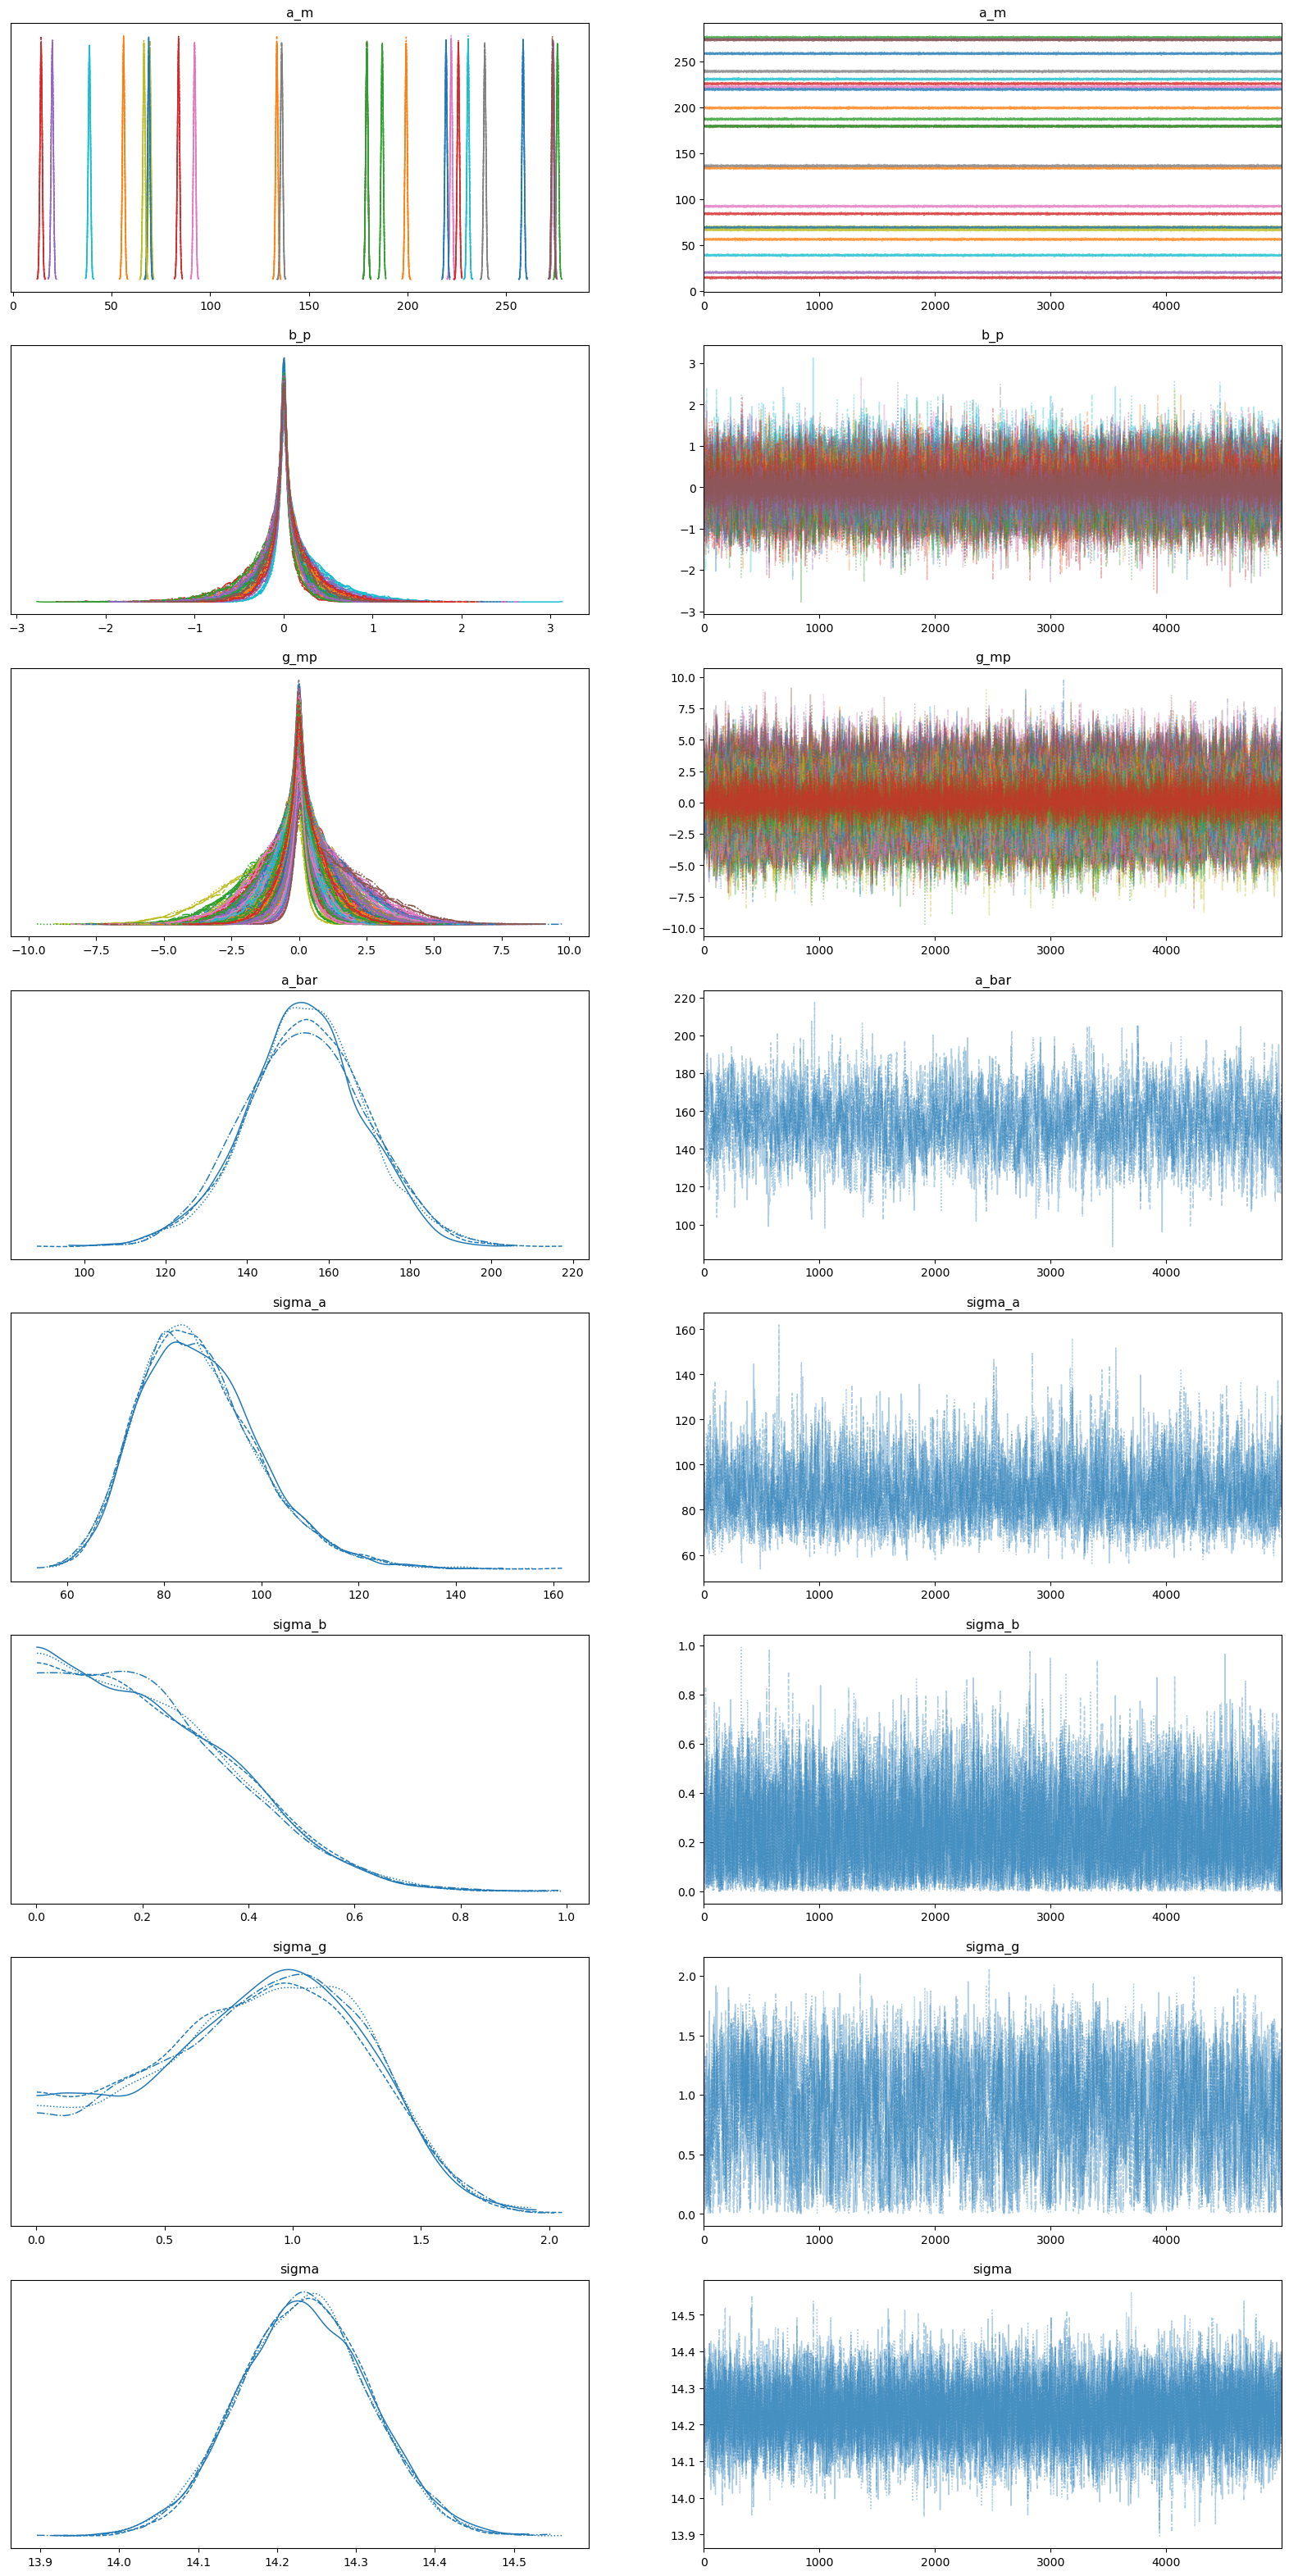

In [4]:
az.plot_trace(idata, var_names=variable_list, figsize=(20, 40))